In [16]:
%pip install pyopencl

import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Input

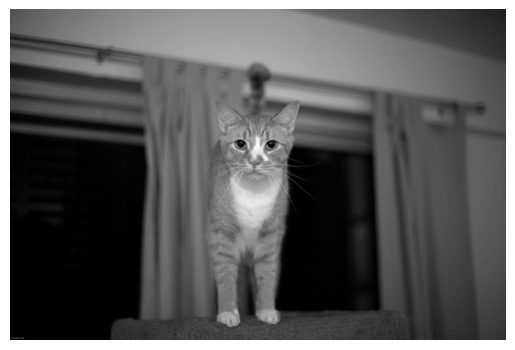

In [17]:
#Definitions of the size of the matrix and the number of iterations to run
P = ['EV','EH',['ROT', 300, 300, 56.3], ['ROT', 0, 300, 90.0]]
img = Image.open("input2.png")
data = np.asarray(img)

fig, ax = plt.subplots()
ax.imshow(data,cmap='gray')
plt.axis('off')
plt.show()

## Kernels


In [18]:
C_EspejHoriz_KernelSource = """
  __kernel void imgEspejHoriz( 
      const int N,
      const int M,
      __global unsigned char *data_g)
  {
    int i = get_global_id(0);
    int j = get_global_id(1);


    char tmp = data_g[i*M + j];
    data_g[i*M + j] = data_g[M*(i+1) - j];
    data_g[M*(i+1) -j] = tmp;
  }
  """
C_EspejVert_KernelSource = """
  __kernel void imgEspejVert( 
      const int N,
      const int M,
      __global unsigned char *data_g)
  {
    int i = get_global_id(0);
    int j = get_global_id(1);

    char tmp = data_g[i*M + j];
    data_g[i*M + j] = data_g[M*(N-i-1) +j];
    data_g[M*(N-i) +j] = tmp;
  }
  """
C_Rotacion_KernelSource = """
  __kernel void parallelRotate(
      const int N,
      const int M,
      const int origin_x,
      const int origin_y,
      const float seno,
      const float coseno,
      __global unsigned char *data_g, 
      __global unsigned char *res_g)
  {
    int i = get_global_id(0);
    int j = get_global_id(1);

    float xf = coseno * (j-origin_x) - seno * (i-origin_y) + origin_x;
    float yf = seno * (j-origin_x) + coseno * (i-origin_y) + origin_y;

    int x = (int) xf;
    int y = (int) yf;

    res_g[y*M + x] = data_g[i*M +j];
  }
  """

## Código Host


In [19]:
def ejercicio1(list):
  
  (N,M) = data.shape
  #Obtener la plataforma
  plataform_list = cl.get_platforms()

  #Obtener los dispositivos
  devices = plataform_list[0].get_devices(device_type = cl.device_type.GPU)

  #Crear el contexto
  context = cl.Context(devices=devices)

  #Crear el Command Queue
  queue = cl.CommandQueue(context, properties=cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE)

  #Crear e inicializar las matrices de entrada
  data_np = data

  #Crear e inicializar vector de salida
  res_np = np.empty_like(data_np)

  #Crear e inicializar los Buffers (OpenCL)
  mf = cl.mem_flags
  data_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf = data_np)

  #Crear buffer de salida (OpenCL)
  res_g = cl.Buffer(context, mf.READ_WRITE, res_np.nbytes)

  #Crear el programa / compilar
  rot_program = cl.Program(context, C_Rotacion_KernelSource).build()
  vert_program = cl.Program(context,  C_EspejVert_KernelSource).build()
  horz_program = cl.Program(context,  C_EspejHoriz_KernelSource).build()

  #Crear kernel
  rot_kernel = rot_program.parallelRotate
  vert_kernel = vert_program.imgEspejVert
  horz_kernel = horz_program.imgEspejHoriz

  #Configurar los argumentos
  rot_kernel.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, np.int32, np.float32, np.float32, None, None])
  vert_kernel.set_scalar_arg_dtypes([np.int32, np.int32, None])
  horz_kernel.set_scalar_arg_dtypes([np.int32, np.int32, None])

  #Definir el espacio indexado, #Ejecutar el kernel
  localRange = None
  for p in list: 
      if p == "EV":
        globalrange = (N//2,M)
        vert_kernel.set_args(N, M, data_g)
        ev = cl.enqueue_nd_range_kernel(queue, vert_kernel, globalrange, localRange)
      elif p == "EH":
        globalrange = (N,M//2)
        horz_kernel.set_args(N, M, data_g) 
        ev = cl.enqueue_nd_range_kernel(queue, horz_kernel, globalrange, localRange)
      elif p[0] == "ROT":
        globalrange = (N,M)
        theta = np.radians(p[3])
        coseno, seno = np.cos(theta), np.sin(theta)
        rot_kernel.set_args(N, M, p[1], p[2], seno, coseno, data_g, res_g)
        ev = cl.enqueue_nd_range_kernel(queue, rot_kernel, globalrange, localRange)
        cl.enqueue_copy(queue, data_g, res_g)

  #Copy result del device al host
  cl.enqueue_copy(queue, res_np, data_g)

  #Show result
  fig, ax = plt.subplots()
  ax.imshow(res_np,cmap='gray')
  plt.axis('off')
  plt.show()


# Output

In [20]:
ejercicio1(["EV"])
ejercicio1(["EH"])
ejercicio1(['EV','EH',['ROT', 300, 300, 56.3]])
ejercicio1(P)

LogicError: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR